#Trabajo práctico 1

Profesor: Ph. D. Saúl Calderón Ramírez

Instituto Tecnológico de Costa Rica

Estudiantes:
            
             Deiber Hernández

             Luis Bonilla Hernández

## 0. Inicialización de Datos y sanitización de valores y tipos

In [1]:
!pip install tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

#tomado de https://www.kaggle.com/code/wailinnoo/intrusion-detection-system-using-kdd99-dataset
import pandas as pd
from tensorflow.keras.utils import get_file

try:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise

print(path)

# This file is a CSV, just no CSV extension or headers
# Download from: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
pd_data_frame = pd.read_csv(path, header=None)

# The CSV file has no column heads, so add them
pd_data_frame.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

#describe the dataset
#transform nominal features using a one hot vector encoding
pd_data_frame.describe()

# Determinar si se puede usar GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import torch
print(f"Usando dispositivo: {device}")


# For now, just drop NA's (rows with missing values), in case there are
pd_data_frame.dropna(inplace=True,axis=1)

# Checkng for DUPLICATE values
pd_data_frame.drop_duplicates(keep='first', inplace = True)

# Filter the DataFrame to keep only 'normal.' and 'back.' outcomes
filtered_df = pd_data_frame[pd_data_frame['outcome'].isin(['normal.', 'back.'])].copy()

list_nominal_features = ["flag", "protocol_type", "service"]

# Apply one-hot encoding to the nominal features
df_encoded = pd.get_dummies(filtered_df, columns=list_nominal_features)

# Convert boolean columns (from one-hot encoding) to integers (0 or 1) in df_encoded
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'bool':
        df_encoded[col] = df_encoded[col].astype(int)

# Display the first few rows of the modified DataFrame to verify
# print("DataFrame with boolean columns converted to integers:")
# display(df_encoded.describe())
# print("Columns after nominal attributes encoded: ")
# for i in df_encoded.columns:
#   print(i)

#Lets analyze the data of each category, using common statistic moments

# Create a DataFrame for attacks (attack_detected == 1)
df_attacks = df_encoded[df_encoded['outcome'] == 'back.'].copy()

# Create a DataFrame for no attacks (attack_detected == 0)
df_no_attacks = df_encoded[df_encoded['outcome'] == 'normal.'].copy()



2144903/2144903 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
/root/.keras/datasets/kddcup.data_10_percent.gz
Usando dispositivo: cuda


## 1.1 Por cada característica del espacio de entrada, compute los siguientes momentos estadísticos (usando la implementación de las fun- ciones correspondientes en pytorch, o la implementacion realizada por su equipo): media, desviación estándar, inclinación y kurtosis. Presente tales momentos de forma compacta y analice los resultados.


In [2]:

#Custom Function to add the statistic moments of Mean, Standard Desviation, Skewness, Kurtosis
def custom_describe(df):
  # Filtrar solo columnas numéricas
  numeric_df = df.select_dtypes(include='number')
  #Convertir a tensor de PyTorch en GPU o CPU
  tensor = torch.tensor(numeric_df.values, dtype=torch.float32, device=device)


  # Calculo de estadísticas
  mean = tensor.mean(dim=0)
  std = tensor.std(dim=0, unbiased=False)

  def skewness(t):
      mean_ = t.mean(dim=0)
      std_ = t.std(dim=0, unbiased=False)
      skew = (((t - mean_)**3).mean(dim=0)) / (std_**3)
      return skew

  def kurtosis(t):
      mean_ = t.mean(dim=0)
      std_ = t.std(dim=0, unbiased=False)
      kurt = (((t - mean_)**4).mean(dim=0)) / (std_**4)
      return kurt - 3  # Fisher kurtosis (como en pandas)

  skew = skewness(tensor)
  kurt = kurtosis(tensor)

  # Convertir resultados a DataFrame (en CPU)
  custom_describe = pd.DataFrame({
      'mean': mean.cpu().numpy(),
      'std': std.cpu().numpy(),
      'skew': skew.cpu().numpy(),
      'kurtosis': kurt.cpu().numpy()
  }, index=numeric_df.columns)

  # Mostrar resumen
  display(custom_describe)
  return custom_describe

print("Resumen de estadísticas:")
print("Attacks")
describe_attacks = custom_describe(df_attacks)
print("No attacks")
describe_no_attacks = custom_describe(df_no_attacks)

Resumen de estadísticas:
Attacks


,mean,std,skew,kurtosis
duration,0.293388,1.659769,6.211482,39.397385
src_bytes,53666.890625,4720.023926,-6.385117,42.711460
dst_bytes,8129.907715,918.663574,-5.925033,35.952263
land,0.000000,0.000000,NaN,NaN
wrong_fragment,0.000000,0.000000,NaN,NaN
...,...,...,...,...
service_tftp_u,0.000000,0.000000,NaN,NaN
service_tim_i,0.000000,0.000000,NaN,NaN
service_time,0.000000,0.000000,NaN,NaN
service_urh_i,0.000000,0.000000,NaN,NaN


No attacks


,mean,std,skew,kurtosis
duration,188.932388,1320.945435,10.840581,164.946335
src_bytes,1270.249146,36017.558594,59.172668,3578.816650
dst_bytes,3720.620361,39526.617188,70.641769,6579.030762
land,0.000011,0.003374,296.359589,87827.015625
wrong_fragment,0.000000,0.000000,NaN,NaN
...,...,...,...,...
service_tftp_u,0.000011,0.003374,296.359589,87827.015625
service_tim_i,0.000023,0.004772,209.554321,43911.007812
service_time,0.000398,0.019958,50.064804,2504.484863
service_urh_i,0.000159,0.012624,79.187851,6268.714844


## 1.2 Por cada característica, grafique el histograma para categoría ataque (backdoor) y normal, y compute la distancia de Jensen-Shannon entre ambas aproximaciones de las densidades. Realice los gráficos para facilitar la comparación, y analice los resultados.

Usando dispositivo: cuda
Calculando momentos para 'back.' (ataques)
Calculando momentos para 'normal.'


,normal_mean,normal_std,normal_skew,normal_kurtosis,back_mean,back_std,back_skew,back_kurtosis
count,8.850578,18.486500,9.788989,142.607300,3.524793,1.761446,2.294674,13.489805
diff_srv_rate,0.017889,0.115963,6.952693,49.552200,0.004587,0.048398,10.946175,123.260406
dst_bytes,3720.620361,39526.617188,70.641769,6579.030762,8129.907715,918.663574,-5.925033,35.952263
dst_host_count,139.642456,102.323669,-0.025722,-1.709484,146.418381,90.679672,-0.056705,-1.559332
dst_host_rerror_rate,0.056157,0.221027,3.890068,13.396597,0.063564,0.109976,4.967799,32.017109
dst_host_same_src_port_rate,0.122985,0.260983,2.556262,5.319401,0.023202,0.078852,9.212126,101.265213
dst_host_serror_rate,0.002349,0.030954,23.756382,625.251831,0.002035,0.005501,3.190155,11.172428
dst_host_srv_count,203.544830,85.431389,-1.390796,0.346068,146.418381,90.679672,-0.056705,-1.559332
dst_host_srv_rerror_rate,0.054160,0.214455,3.889680,13.448935,0.063564,0.109976,4.967799,32.017109
dst_host_srv_serror_rate,0.001183,0.016544,43.772030,2172.992188,0.002035,0.005501,3.190155,11.172428


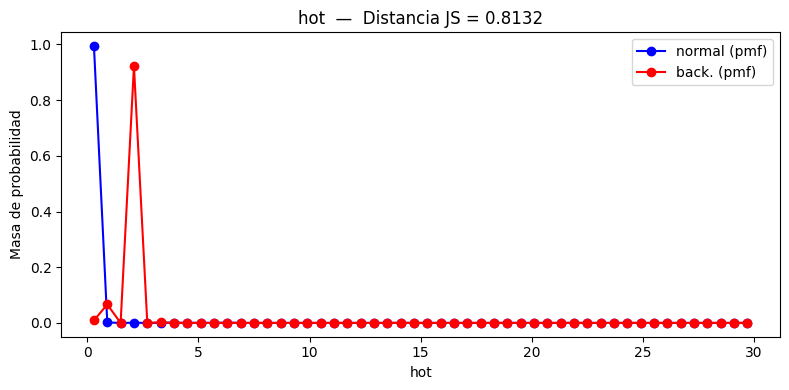

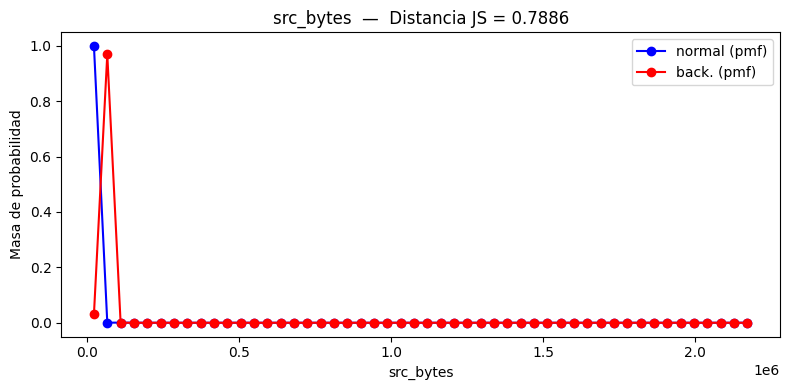

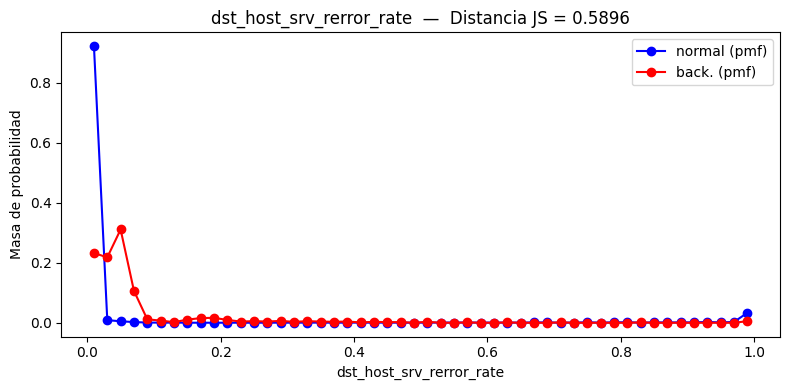

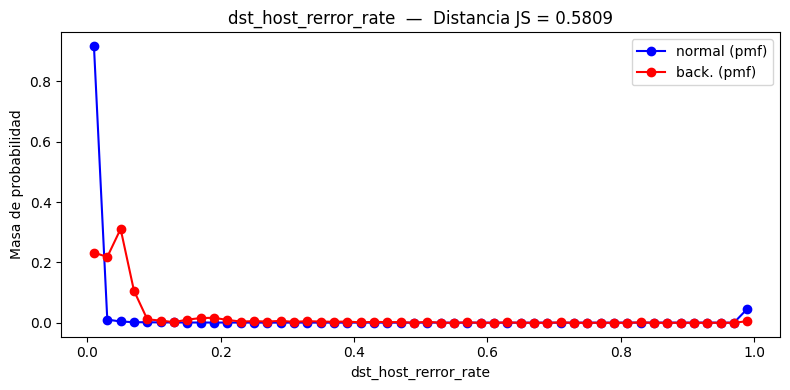

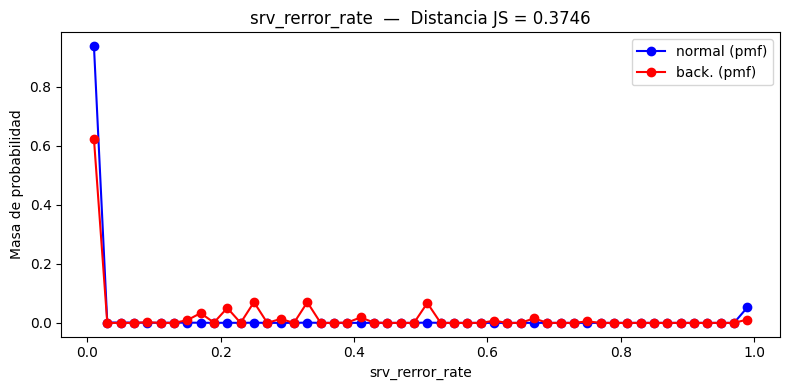

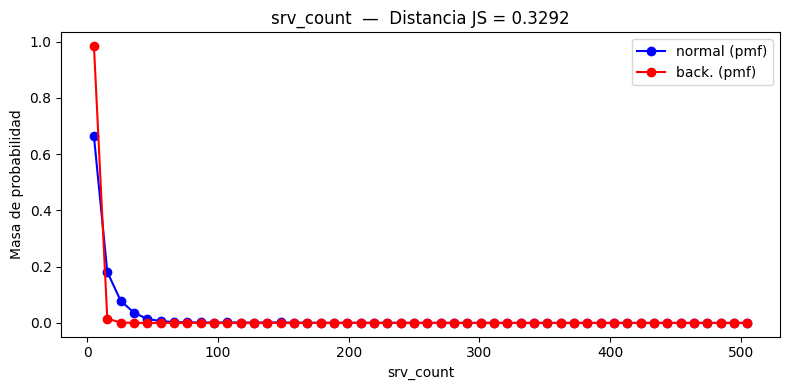

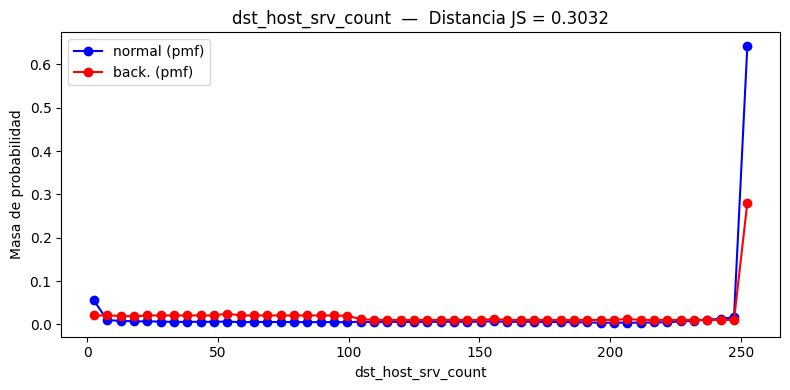

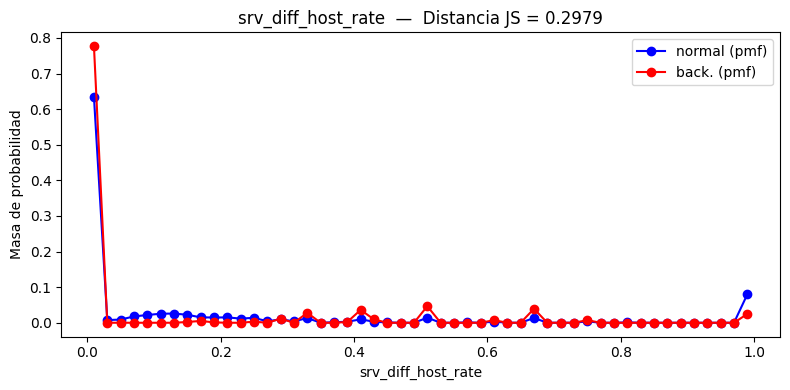

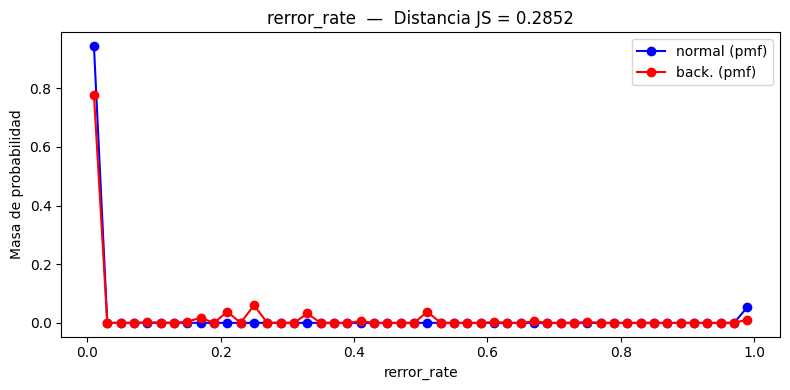

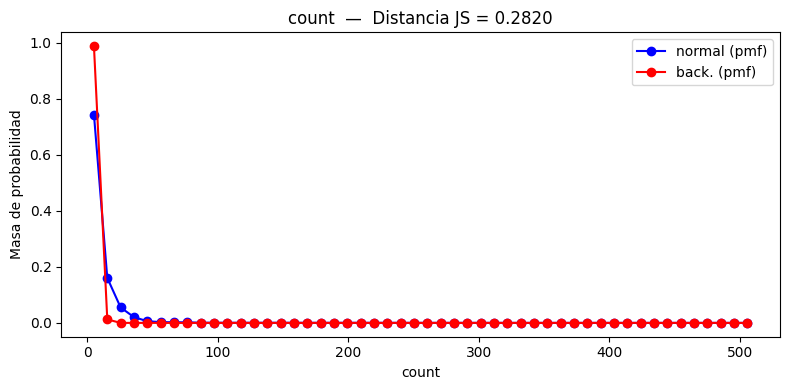

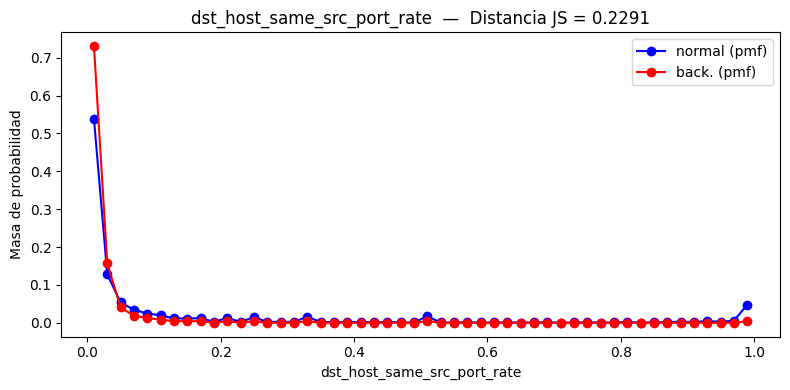

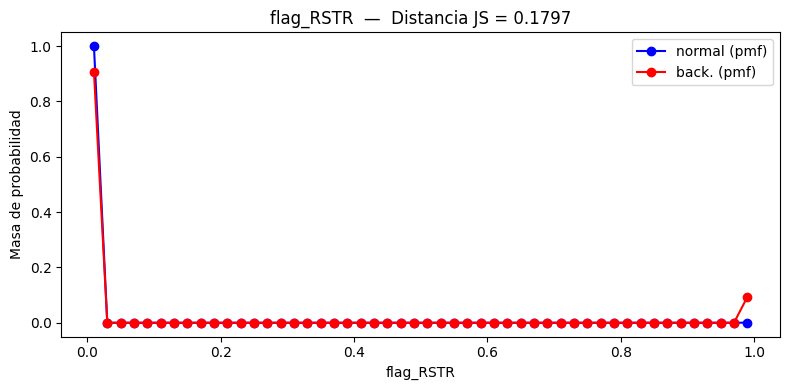

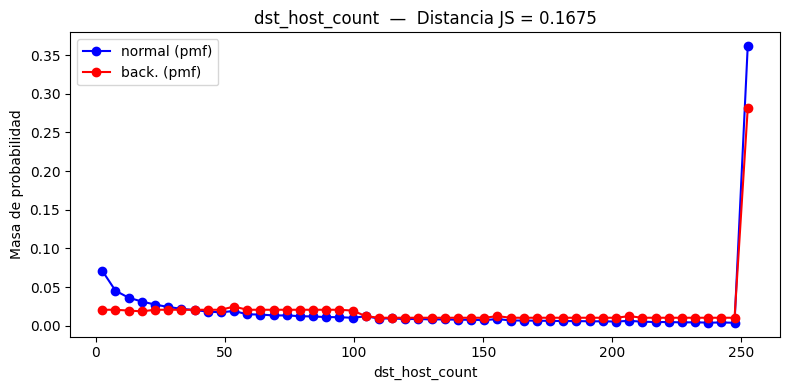

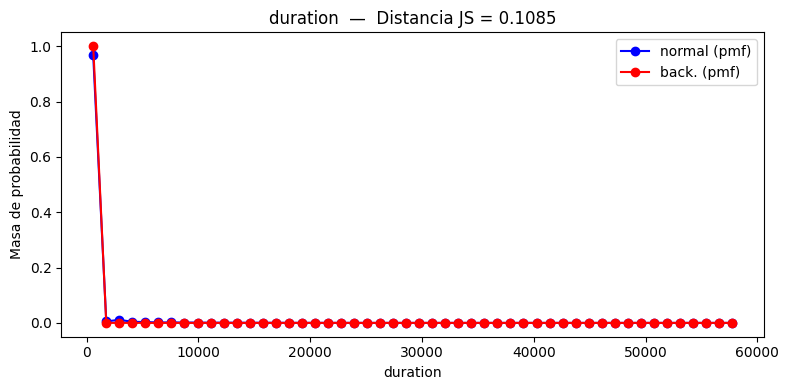

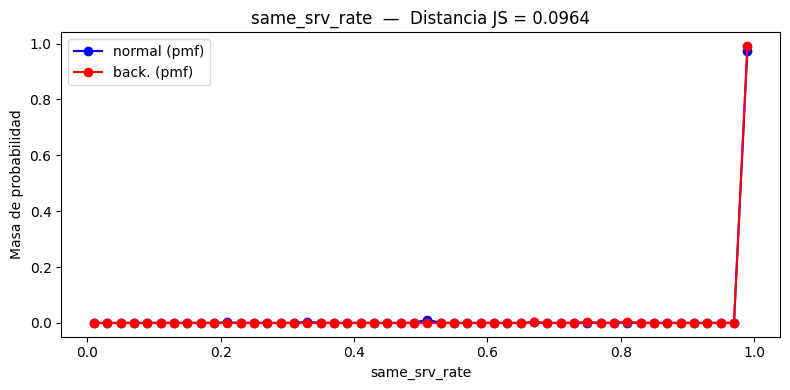

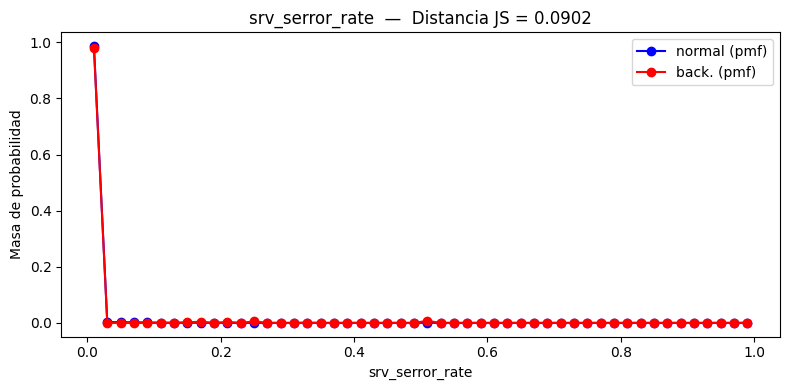

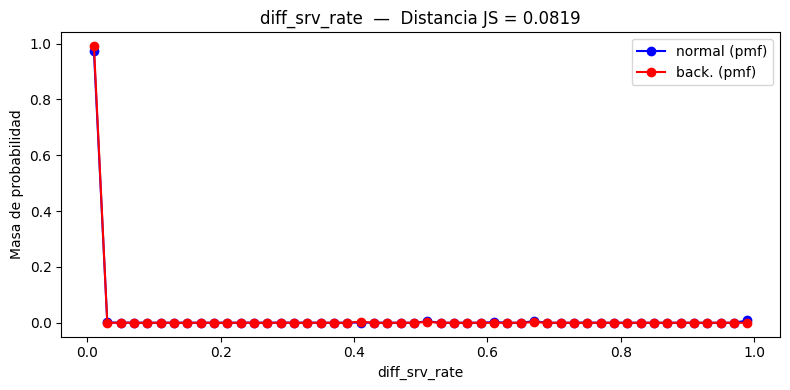

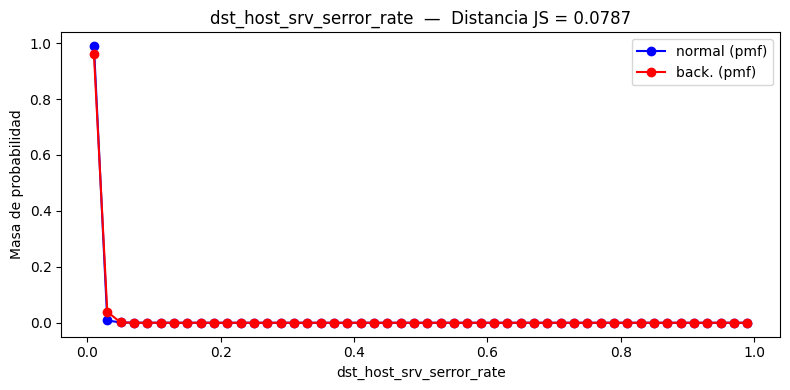

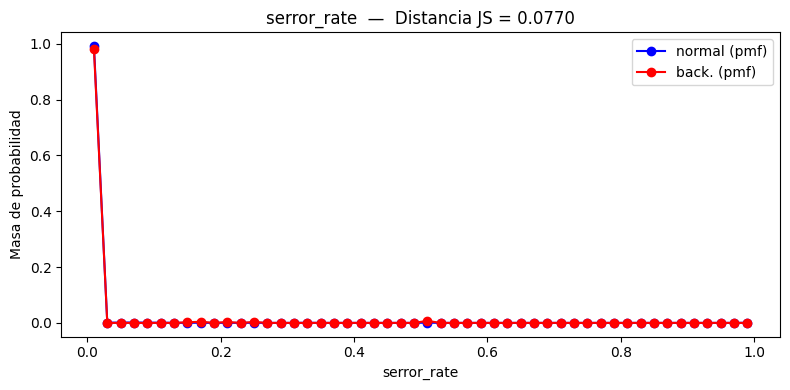

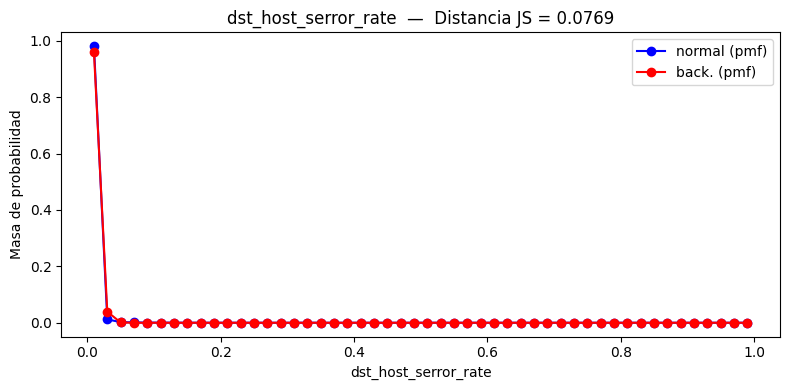

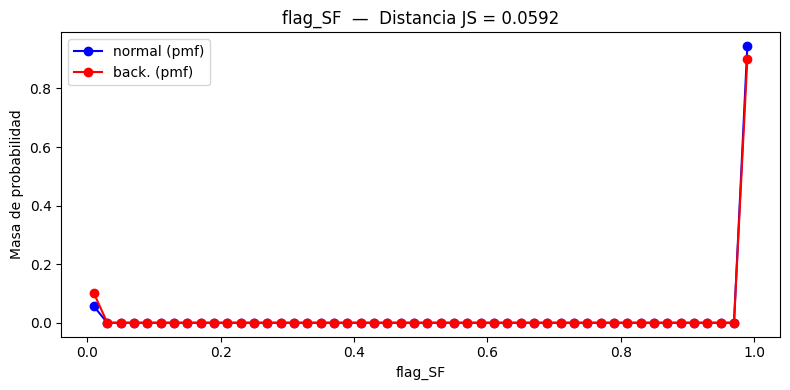

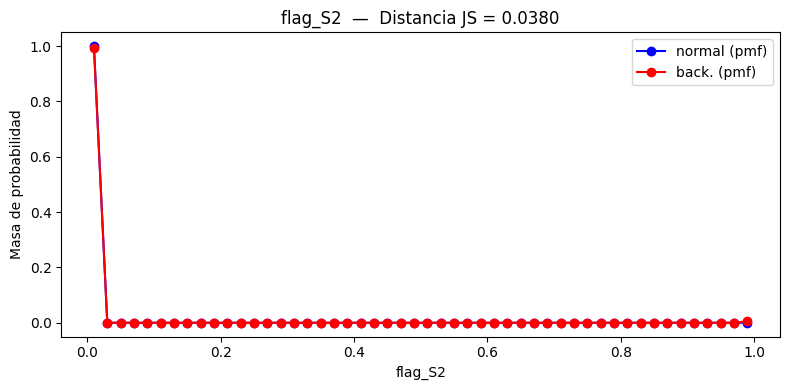

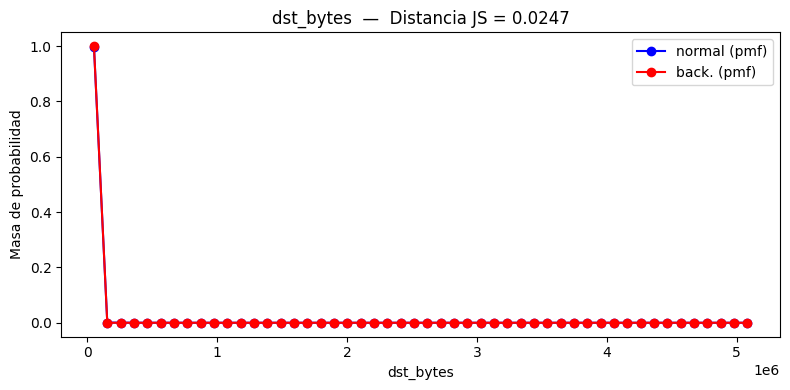

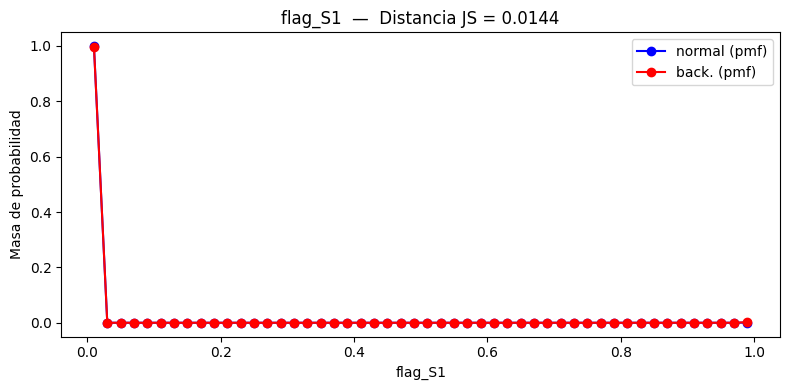

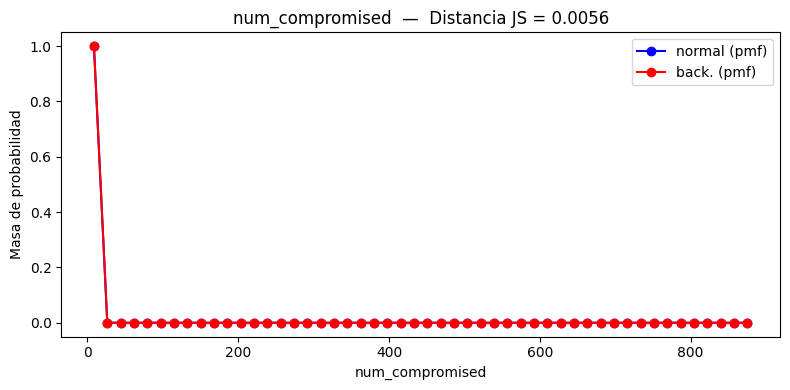

30 mayores distancias JS (ordenadas):


,0
hot,0.813179
src_bytes,0.788602
dst_host_srv_rerror_rate,0.589621
dst_host_rerror_rate,0.580869
srv_rerror_rate,0.374571
srv_count,0.329243
dst_host_srv_count,0.303169
srv_diff_host_rate,0.297912
rerror_rate,0.285151
count,0.282032


In [3]:
# --- Momentos usando PyTorch + histogramas JS adecuados ---
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy.stats import entropy
from math import sqrt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Usando dispositivo:", device)

# Ayudante: obtener solo columnas numéricas (excluyendo outcome)
def get_numeric_df(df):
    numeric = df.select_dtypes(include=[np.number]).copy()
    # eliminar columnas que son constantes (varianza cero)
    numeric = numeric.loc[:, numeric.nunique() > 1]
    return numeric

num_attacks = get_numeric_df(df_attacks)
num_normal  = get_numeric_df(df_no_attacks)

# Asegurar que ambas tengan las mismas columnas numéricas (intersección)
common_cols = sorted(list(set(num_attacks.columns).intersection(set(num_normal.columns))))
num_attacks = num_attacks[common_cols]
num_normal  = num_normal[common_cols]

# 1) Cálculo de momentos con PyTorch
def compute_moments_torch(df_num: pd.DataFrame):
    t = torch.tensor(df_num.values, dtype=torch.float32, device=device)  # forma (n_muestras, n_atributos)
    mean = t.mean(dim=0)
    std  = t.std(dim=0, unbiased=False)
    # asimetría (skewness) y curtosis (kurtosis de Fisher)
    m = mean
    s = std
    # evitar división por cero para columnas constantes (ya filtradas)
    skew = (((t - m)**3).mean(dim=0)) / (s**3 + 1e-20)
    kurt = (((t - m)**4).mean(dim=0)) / (s**4 + 1e-20) - 3.0
    df_stats = pd.DataFrame({
        'mean': mean.cpu().numpy(),
        'std': std.cpu().numpy(),
        'skew': skew.cpu().numpy(),
        'kurtosis': kurt.cpu().numpy()
    }, index=df_num.columns)
    return df_stats

print("Calculando momentos para 'back.' (ataques)")
mom_back = compute_moments_torch(num_attacks)
print("Calculando momentos para 'normal.'")
mom_norm = compute_moments_torch(num_normal)

# Combinar en una sola tabla para comparar
mom_compare = pd.concat(
    [mom_norm.add_prefix('normal_'), mom_back.add_prefix('back_')],
    axis=1
)
display(mom_compare)

# 2) Histogramas + distancias de Jensen-Shannon
def jensen_shannon(p, q):
    # p, q son arreglos numpy con valores positivos que suman 1
    p = np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)
    # Asegurar normalización
    p = p / (p.sum() + 1e-20)
    q = q / (q.sum() + 1e-20)
    m = 0.5 * (p + q)
    # Divergencia KL base e; JS = 0.5 KL(p||m) + 0.5 KL(q||m)
    js = 0.5 * (entropy(p, m) + entropy(q, m))
    return sqrt(js)  # retorna la distancia de Jensen-Shannon (raíz de la divergencia)

js_results = {}

# elegir número de bins
NBINS = 50

# Calcular JS distances para todos los atributos primero
for col in common_cols:
    a = num_normal[col].dropna().values
    b = num_attacks[col].dropna().values
    if a.size < 2 or b.size < 2:
        js_results[col] = np.nan
        continue

    # calcular bins compartidos usando el rango combinado
    try:
        all_min = min(a.min(), b.min())
        all_max = max(a.max(), b.max())
    except:
        all_min = 0.0
        all_max = 1.0

    if all_min == all_max:
        # degenerado, omitir
        js_results[col] = 0.0
        continue

    bins = np.linspace(all_min, all_max, NBINS + 1)

    # conteos de histograma (no densidad). Usar mismos bins para ambos
    cnt_a, _ = np.histogram(a, bins=bins, density=False)
    cnt_b, _ = np.histogram(b, bins=bins, density=False)

    # convertir conteos -> masa de probabilidad (suma=1)
    pmf_a = cnt_a.astype(np.float64) / (cnt_a.sum() + 1e-20)
    pmf_b = cnt_b.astype(np.float64) / (cnt_b.sum() + 1e-20)

    # estabilidad numérica: agregar pequeño epsilon para evitar ceros (opcional)
    eps = 1e-12
    pmf_a += eps
    pmf_b += eps
    pmf_a /= pmf_a.sum()
    pmf_b /= pmf_b.sum()

    jsd = jensen_shannon(pmf_a, pmf_b)
    js_results[col] = jsd

# Ordenar atributos por JS distance (descendente)
sorted_cols = pd.Series(js_results).sort_values(ascending=False).index

# Graficar histogramas en orden de JS distance (de mayor a menor)
for col in sorted_cols:
    if pd.isna(js_results[col]) or js_results[col] == 0.0:
        continue  # Omitir atributos con JS inválido o cero
    a = num_normal[col].dropna().values
    b = num_attacks[col].dropna().values
    all_min = min(a.min(), b.min())
    all_max = max(a.max(), b.max())
    bins = np.linspace(all_min, all_max, NBINS + 1)
    cnt_a, _ = np.histogram(a, bins=bins, density=False)
    cnt_b, _ = np.histogram(b, bins=bins, density=False)
    pmf_a = cnt_a.astype(np.float64) / (cnt_a.sum() + 1e-20)
    pmf_b = cnt_b.astype(np.float64) / (cnt_b.sum() + 1e-20)
    eps = 1e-12
    pmf_a += eps
    pmf_b += eps
    pmf_a /= pmf_a.sum()
    pmf_b /= pmf_b.sum()

    plt.figure(figsize=(8, 4))
    centers = (bins[:-1] + bins[1:]) / 2.0
    plt.plot(centers, pmf_a, marker='o', color='blue', label='normal (pmf)')
    plt.plot(centers, pmf_b, marker='o', color='red', label='back. (pmf)')
    plt.title(f"{col}  —  Distancia JS = {js_results[col]:.4f}")
    plt.xlabel(col)
    plt.ylabel('Masa de probabilidad')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Presentar resumen JS ordenado por distancia
js_series = pd.Series(js_results).sort_values(ascending=False)
print("30 mayores distancias JS (ordenadas):")
display(js_series.head(30))  # atributos más relevantes según distancia JS

## 2. 1 Implementación de la clasificación multi-clase con árboles de decisión


1.   Implemente el método calculate_gini(data_partition_torch, num_classes = 2).
2.   Implemente los metodos select_best_feature_and_thresh(data_torch, num_classes = 2) y create_with_children, de la clase Node_CART.
3.   Implemente la función test_CART lacual evalúe un CART previamente entrenado para un conjunto de datos D representado en un tensor.





In [4]:
class Node_CART:
    def __init__(self, num_classes=4, ref_CART=None, current_depth=0, min_samples_leaf=1):
        self.ref_CART = ref_CART
        self.threshold_value = 0
        self.feature_num = 0
        self.node_right = None
        self.node_left = None
        self.data_torch_partition = None
        self.gini = 0
        self.dominant_class = None
        self.accuracy_dominant_class = None
        self.num_classes = num_classes
        self.current_depth = current_depth
        self.max_depth = None  # Opcional: se puede establecer externamente si es necesario
        self.min_samples_leaf = min_samples_leaf
    def to_xml(self, current_str=""):
        str_node = "<node><thresh>" + str(self.threshold_value) + "</thresh>" + "<feature>" + str(self.feature_num) + "</feature><depth>" + str(self.current_depth)+ "</depth>"
        str_node += "<gini>" + str(self.gini) + "</gini>"
        if self.node_right is not None:
            str_node += self.node_right.to_xml(current_str)
        if self.node_left is not None:
            str_node += self.node_left.to_xml(current_str)
        if self.is_leaf():
            str_node += "<dominant_class>" + str(self.dominant_class) + "</dominant_class><acc_dominant_class>"  + str(self.accuracy_dominant_class) + "</acc_dominant_class>"
        str_node += "</node>"
        return str_node

    def is_leaf(self):
        return (self.node_left is None and self.node_right is None)

    @staticmethod
    def calculate_gini(data_partition_torch, num_classes=2):
        if data_partition_torch.numel() == 0:
            return 0.0
        labels = data_partition_torch[:, -1].long()
        # Contar cuántos ejemplos hay de cada clase
        counts = torch.bincount(labels, minlength=num_classes)
        probs = counts.float() / counts.sum()
        gini = 1.0 - torch.sum(probs ** 2)
        return gini.item()

    def create_with_children(self, data_torch, current_depth, min_gini=0.000001):
        labels = data_torch[:, -1].long()
        counts = torch.bincount(labels, minlength=self.num_classes).float()
        self.dominant_class = torch.argmax(counts).item()

        # Si el nodo es puro, convertir en hoja
        if (counts > 0).sum() == 1:
            return self

        # Si se alcanzó la profundidad máxima
        if self.max_depth is not None and current_depth >= self.max_depth:
            #print("Profundidad máxima alcanzada")
            return self

        # Si hay menos de min_samples_leaf*2, no se puede dividir más (ambas hojas deben tener al menos min_samples_leaf)
        if data_torch.shape[0] < self.min_samples_leaf * 2:
            return self

        # Seleccionar la mejor división
        feature, thresh, gini = self.select_best_feature_and_thresh(data_torch, self.num_classes)
        # Si no hay una buena división, convertir en hoja
        if feature is None or gini < min_gini:
            return self

        self.feature_num = feature
        self.threshold_value = thresh
        self.gini = gini

        # Particionar los datos
        left_mask = data_torch[:, feature] < thresh
        right_mask = ~left_mask

        left_partition = data_torch[left_mask]
        right_partition = data_torch[right_mask]

        # Si alguna partición tiene menos de min_samples_leaf, no dividir
        if left_partition.shape[0] < self.min_samples_leaf or right_partition.shape[0] < self.min_samples_leaf:
            return self

        # Crear nodos hijos
        self.node_left = Node_CART(num_classes=self.num_classes, current_depth=current_depth + 1, min_samples_leaf=self.min_samples_leaf)
        self.node_right = Node_CART(num_classes=self.num_classes, current_depth=current_depth + 1, min_samples_leaf=self.min_samples_leaf)
        self.node_left.max_depth = self.max_depth
        self.node_right.max_depth = self.max_depth

        self.node_left.create_with_children(left_partition, current_depth + 1, min_gini)
        self.node_right.create_with_children(right_partition, current_depth + 1, min_gini)

        return self

    def select_best_feature_and_thresh(self, data_torch, num_classes=2):
      """
      Selecciona la mejor característica (feature) y el mejor umbral (threshold)
      para dividir un conjunto de datos usando el índice Gini como criterio de impureza.

      Parámetros:
      -----------
      data_torch : torch.Tensor
          Tensor de datos donde cada fila es una muestra y
          la última columna contiene las etiquetas de clase.
      num_classes : int, opcional (default=2)
          Número total de clases posibles en las etiquetas.

      Retorna:
      --------
      best_feature : int o None
          Índice de la característica que genera la mejor división.
          Devuelve None si no es posible dividir.
      best_thresh : float o None
          Valor del umbral de división para la característica seleccionada.
          Devuelve None si no hay división posible.
      best_gini : float
          Valor mínimo del índice Gini ponderado encontrado.
      """

      # Cantidad de muestras y características (sin incluir la etiqueta)
      n_samples, n_features = data_torch.shape[0], data_torch.shape[1] - 1

      # Inicializamos los mejores valores como "no encontrados"
      best_gini = float('inf')
      best_feature = None
      best_thresh = None

      # Extraemos las etiquetas (última columna)
      labels = data_torch[:, -1].long()

      # Recorremos cada característica para evaluar posibles divisiones
      for feature_idx in range(n_features):
          feature_values = data_torch[:, feature_idx]

          # Ordenamos los valores de la característica y sus etiquetas asociadas
          sorted_vals, sorted_idx = torch.sort(feature_values)
          sorted_labels = labels[sorted_idx]

          # Obtenemos valores únicos consecutivos para evaluar como posibles umbrales
          uniq_vals, uniq_idx = torch.unique_consecutive(sorted_vals, return_inverse=True)
          if len(uniq_vals) == 1:
              continue  # No es posible dividir si todos los valores son iguales

          # Usamos los valores únicos (excepto el último) como posibles umbrales
          thresholds = uniq_vals[:-1]

          # Evaluamos cada umbral para calcular el índice Gini ponderado
          for i, thresh in enumerate(thresholds):
              left_mask = sorted_vals < thresh
              right_mask = ~left_mask

              # Saltamos divisiones vacías (sin datos en un lado)
              if left_mask.sum() == 0 or right_mask.sum() == 0:
                  continue

              # Separamos etiquetas a izquierda y derecha
              left_labels = sorted_labels[left_mask]
              right_labels = sorted_labels[right_mask]

              # Calculamos el Gini para cada partición
              gini_left = self.calculate_gini(left_labels.unsqueeze(1), num_classes)
              gini_right = self.calculate_gini(right_labels.unsqueeze(1), num_classes)

              # Índice Gini ponderado por el tamaño de cada partición
              weighted_gini = (left_labels.size(0) * gini_left +
                              right_labels.size(0) * gini_right) / n_samples

              # Actualizamos si encontramos una mejor división
              if weighted_gini < best_gini:
                  best_gini = weighted_gini
                  best_feature = feature_idx
                  best_thresh = thresh.item()

      return best_feature, best_thresh, best_gini

    def evaluate_node(self, input_torch):
        feature_val_input = input_torch[self.feature_num]
        if self.is_leaf():
            return self.dominant_class
        else:
            if feature_val_input < self.threshold_value:
                return self.node_left.evaluate_node(input_torch)
            else:
                return self.node_right.evaluate_node(input_torch)

def test_CART(root_node, D):
    """
    Evalúa un árbol CART previamente entrenado (root_node) sobre un conjunto de datos D (tensor).
    Calcula y retorna la tasa de aciertos (accuracy), definida como:
        accuracy = c / n
    donde:
        c = número de estimaciones correctas (predicción == etiqueta real)
        n = número total de muestras

    Parámetros:
        root_node (Node_CART): nodo raíz del árbol entrenado.
        D (torch.Tensor): conjunto de datos, última columna es la etiqueta.

    Retorna:
        float: tasa de aciertos (accuracy).
    """
    # Contador de aciertos
    correct = 0
    n = D.shape[0]

    # Para cada muestra en D
    for i in range(n):
        sample = D[i, :-1]  # Todas las columnas menos la última (atributos)
        true_label = D[i, -1].item()  # Última columna (etiqueta real)
        pred_label = root_node.evaluate_node(sample)  # Predicción del árbol

        if pred_label == true_label:
            correct += 1

    accuracy = correct / n
    return accuracy


## 2.2 Pruebas Unitarias calculate_gini, select_best_feature_and_thresh,  test_card

In [5]:
###-----------------------------------------------------------------------------
### Unit Tests función: calculate_gini
###-----------------------------------------------------------------------------

# Prueba unitaria 1: Gini para un solo grupo homogéneo (impureza debe ser 0)
def test_gini_homogeneous():
    node = Node_CART(num_classes=2)
    # Todos los elementos son de la clase 0
    data = torch.tensor([[1, 2, 0], [2, 3, 0], [3, 4, 0]], dtype=torch.float32)
    gini = node.calculate_gini(data, num_classes=2)
    print('Test 1 - Gini homogéneo:', gini)
    assert abs(gini - 0.0) < 1e-6, f"Esperado 0.0, obtenido {gini}"

# Prueba unitaria 2: Gini para dos clases balanceadas (impureza máxima)
def test_gini_balanced():
    node = Node_CART(num_classes=2)
    # Mitad clase 0, mitad clase 1
    data = torch.tensor([[1, 2, 0], [2, 3, 1], [3, 4, 0], [4, 5, 1]], dtype=torch.float32)
    gini = node.calculate_gini(data, num_classes=2)
    print('Test 2 - Gini balanceado:', gini)
    assert abs(gini - 0.5) < 1e-6, f"Esperado 0.5, obtenido {gini}"

# Ejecutar pruebas
print(" *** Unit test de calculate_gini ")
test_gini_homogeneous()
test_gini_balanced()

def test_select_best_feature_and_thresh():
    # El feature 0 separa perfectamente las clases con threshold 2
    # [feature0, feature1, clase]
    data = torch.tensor([
        [1.0, 10.0, 0],
        [2.0, 20.0, 0],
        [3.0, 30.0, 1],
        [4.0, 40.0, 1]
    ])

    node = Node_CART(num_classes=2)
    best_feature, best_thresh, best_gini = node.select_best_feature_and_thresh(data, num_classes=2)

    print("Mejor feature:", best_feature)
    print("Mejor threshold:", best_thresh)
    print("Mejor gini:", best_gini)


    # Esperamos que el mejor feature sea 0 y el mejor threshold sea 3.0 (ambos separan perfectamente)
    assert best_feature == 0, "El mejor feature debería ser la columna 0"
    assert best_thresh == 3, "El mejor threshold debería ser  3.0"
    assert best_gini == 0.0, "El gini debería ser 0 para una separación perfecta"

###-----------------------------------------------------------------------------
### Unit Tests función: select_best_feature_and_thresh
###-----------------------------------------------------------------------------

def test_select_best_feature_and_thresh_feature2():
    # Dataset: solo la columna 2 permite separación perfecta con threshold 12.5
    # [feature0, feature1, feature2, clase]
    data = torch.tensor([
        [0.0, 1.0, 10.0, 1],
        [0.0, 1.0, 11.0, 1],
        [0.0, 1.0, 12.0, 1],
        [0.0, 1.0, 13.0, 0],
        [0.0, 1.0, 14.0, 0],
        [0.0, 1.0, 15.0, 0],
        [0.0, 1.0, 16.0, 0],
        [0.0, 1.0, 17.0, 0],
    ])

    node = Node_CART(num_classes=2)
    best_feature, best_thresh, best_gini = node.select_best_feature_and_thresh(data, num_classes=2)

    print("Mejor feature:", best_feature)
    print("Mejor threshold:", best_thresh)
    print("Mejor gini:", best_gini)

    # Esperamos que el mejor feature sea 2 (columna 2) y threshold  13.0
    assert best_feature == 2, "El mejor feature debería ser la columna 2"

    assert best_thresh == 13.0 , "El mejor threshold debería ser entre 13"
    assert best_gini == 0.0, "El gini debería ser 0 para una separación perfecta"

print(" *** Unit test de select_best_feature_and_thresh ")
print("Test #1 de la función select_best_feature_and_thresh. El feature 0 separa perfectamente las clases con threshold 2.5")
test_select_best_feature_and_thresh()

print("_____________________________________________________")

print("Test #2 de la función select_best_feature_and_thresh. El feature 2 separa perfectamente las clases con threshold 12.5")
test_select_best_feature_and_thresh_feature2()


###-----------------------------------------------------------------------------
### Unit Tests función: test_card
###-----------------------------------------------------------------------------


def test_CART_simple_CART():
    # Dataset perfectamente separable por feature 0 con threshold 2.0
    data = torch.tensor([
        [1.0, 10.0, 0],
        [2.0, 20.0, 0],
        [3.0, 30.0, 1],
        [4.0, 40.0, 1]
    ])

    node = Node_CART(num_classes=2)
    node.create_with_children(data, current_depth=0, min_gini=0.0)
    acc = test_CART(node, data)  # accuracy
    print("Accuracy árbol perfectamente valanceado:", acc)
    assert acc == 1.0, "El accuracy debería ser 1"

def test_CART_DEPTH_2():
  data = torch.tensor([
      [1.0, 0.0, 1.0, 0],
      [1.0, 0.0, 2.0, 0],
      [1.0, 0.0, 3.0, 1],
      [1.0, 0.0, 4.0, 0],
      [1.0, 0.0, 5.0, 0],
      [1.0, 0.0, 6.0, 0],
  ])

  node = Node_CART(num_classes=2)
  node.create_with_children(data, current_depth=0)
  acc = test_CART(node, data)  # accuracy
  print("Accuracy árbol usando un min gini mayor a 0", acc)
  assert acc < 1.0 and acc >0, "El accuracy debería ser menor que uno y mayor a 0, usando un min gini mayor a 0"

def test_CART_DEPTH_2_Gin0():
  data = torch.tensor([
      [1.0, 0.0, 1.0, 0],
      [1.0, 0.0, 2.0, 0],
      [1.0, 0.0, 3.0, 1],
      [1.0, 0.0, 4.0, 0],
      [1.0, 0.0, 5.0, 0],
      [1.0, 0.0, 6.0, 0],
  ])

  node = Node_CART(num_classes=2)
  node.create_with_children(data, current_depth=0, min_gini=0)
  acc = test_CART(node, data)  # accuracy
  print("Accuracy árbol usando un min gini 0", acc)
  assert acc < 1 , "El accuracy debería ser igual a 1"

print(" *** Unit test de test_card ")
test_CART_simple_CART()
test_CART_DEPTH_2()
test_CART_DEPTH_2_Gin0()

 *** Unit test de calculate_gini 
Test 1 - Gini homogéneo: 0.0
Test 2 - Gini balanceado: 0.5
 *** Unit test de select_best_feature_and_thresh 
Test #1 de la función select_best_feature_and_thresh. El feature 0 separa perfectamente las clases con threshold 2.5
Mejor feature: 0
Mejor threshold: 3.0
Mejor gini: 0.0
_____________________________________________________
Test #2 de la función select_best_feature_and_thresh. El feature 2 separa perfectamente las clases con threshold 12.5
Mejor feature: 2
Mejor threshold: 13.0
Mejor gini: 0.0
 *** Unit test de test_card 
Accuracy árbol perfectamente valanceado: 1.0
Accuracy árbol usando un min gini mayor a 0 0.8333333333333334
Accuracy árbol usando un min gini 0 0.8333333333333334


## 3.  Evaluación del CART

### 3.1 Evalúe el CART implementado con el conjunto de datos provisto usándolo como conjunto de datos de entrenamiento y prueba.

In [6]:
data = df_encoded.copy();
data['outcome'] = np.where(data['outcome'] == 'back.', 1, 0)

# Move 'outcome' column to the end
outcome_col = data.pop('outcome')
data['outcome'] = outcome_col

display(data[data['outcome']==1])

from sklearn.metrics import f1_score

data_torch = torch.tensor(data.values, dtype=torch.float32, device = device)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,service_shell,service_smtp,service_ssh,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,outcome
39723,0,54540,8314,0,0,0,2,0,1,1,...,0,0,0,0,0,0,0,0,0,1
39724,0,54540,8314,0,0,0,2,0,1,1,...,0,0,0,0,0,0,0,0,0,1
39725,0,54540,8314,0,0,0,2,0,1,1,...,0,0,0,0,0,0,0,0,0,1
39726,0,54540,8314,0,0,0,2,0,1,1,...,0,0,0,0,0,0,0,0,0,1
39727,0,54540,8314,0,0,0,2,0,1,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480558,0,54540,8314,0,0,0,2,0,1,1,...,0,0,0,0,0,0,0,0,0,1
480559,0,54540,8314,0,0,0,2,0,1,1,...,0,0,0,0,0,0,0,0,0,1
480560,0,54540,8314,0,0,0,2,0,1,1,...,0,0,0,0,0,0,0,0,0,1
480561,0,54540,8314,0,0,0,2,0,1,1,...,0,0,0,0,0,0,0,0,0,1


### 3.1.1 Reporte la tasa de aciertos y el F1-score promedio de todas las clases, obtenida e incluya el código de la evaluación. Pruebe con una profundidad máxima de 3 y 4 nodos, siempre con mínimo 2 observaciones por hoja.

In [7]:
# Entrena el árbol con todo el dataset Max Depth = 3
node = Node_CART(num_classes=2,  min_samples_leaf=2)
node.max_depth = 3
node.create_with_children(data_torch, current_depth=0)

# Evalúa el árbol con el mismo dataset
y_true = data_torch[:, -1].cpu().numpy()
y_pred = [node.evaluate_node(row[:-1]) for row in data_torch]

accuracy = sum([yt == yp for yt, yp in zip(y_true, y_pred)]) / len(y_true)
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy for Max Depth = 3:", accuracy)
print("F1-score promedio:", f1)

Accuracy for Max Depth = 3: 0.9997184684684685
F1-score promedio: 0.993387773580533


In [8]:
# Entrena el árbol con todo el dataset Max Depth = 4
node = Node_CART(num_classes=2,  min_samples_leaf=2)
node.max_depth = 4
node.create_with_children(data_torch, current_depth=0)

# Evalúa el árbol con el mismo dataset
y_true = data_torch[:, -1].cpu().numpy()
y_pred = [node.evaluate_node(row[:-1]) for row in data_torch]

accuracy = sum([yt == yp for yt, yp in zip(y_true, y_pred)]) / len(y_true)
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy for Max Depth = 4:", accuracy)
print("F1-score promedio:", f1)

Accuracy for Max Depth = 4: 0.9997184684684685
F1-score promedio: 0.993387773580533


###3.2 Para una profundidad máxima de 2 y 3 nodos: evalúe el CART implementado usando 10 particiones aleatorias del conjunto de datos, con un 70 % del conjunto de datos como conjunto de datos de en- trenamiento, y el restante 30 % como conjunto de datos de prueba.

In [9]:
import torch
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import time
import pandas as pd


results = []
accs, f1s, train_times, eval_times = [], [], [], []
bestNode = Node_CART(num_classes=2)
bestF1Score =0;
for max_depth in [3, 4]:
  for i in range(10):
      print("Analizing Maxdepth:"+str(max_depth)+" Iteration:"+str(i))
      # Split
      train_idx, test_idx = train_test_split(
          np.arange(data_torch.shape[0]), test_size=0.3, random_state=i, shuffle=True
      )
      train_data = data_torch[train_idx]
      test_data = data_torch[test_idx]

      # Train
      node = Node_CART(num_classes=2, min_samples_leaf=2)
      node.max_depth = max_depth
      t0 = time.time()
      node.create_with_children(train_data, current_depth=0)
      train_time = time.time() - t0

      # Evaluate
      t1 = time.time()
      y_true = test_data[:, -1].cpu().numpy()
      y_pred = [node.evaluate_node(row[:-1]) for row in test_data]
      eval_time = time.time() - t1

      acc = np.mean(y_true == y_pred)
      f1 = f1_score(y_true, y_pred, average='macro')
      if f1 > bestF1Score:
        bestF1Score = f1
        bestNode = node

      accs.append(acc)
      f1s.append(f1)
      train_times.append(train_time)
      eval_times.append(eval_time)

      print("Accuracy:", acc)
      print("F1-score:", f1)
      print("Train time:", train_time)
      print("Eval time:", eval_time)

      results.append({
          "max_depth": max_depth,
          "accuracy_mean": np.mean(accs),
          "accuracy_std": np.std(accs),
          "f1_mean": np.mean(f1s),
          "f1_std": np.std(f1s),
          "train_time_mean": np.mean(train_times),
          "train_time_std": np.std(train_times),
          "eval_time_mean": np.mean(eval_times),
          "eval_time_std": np.std(eval_times),
      })

# Mostrar tabla de resultados
df_results = pd.DataFrame(results)
display(df_results)

Analizing Maxdepth:3 Iteration:0
Accuracy: 0.9996996996996997
F1-score: 0.9927812703230002
Train time: 37.05116057395935
Eval time: 2.715365171432495
Analizing Maxdepth:3 Iteration:1
Accuracy: 0.9995495495495496
F1-score: 0.9898861047835991
Train time: 35.99000406265259
Eval time: 2.429051160812378
Analizing Maxdepth:3 Iteration:2
Accuracy: 0.9990615615615616
F1-score: 0.9811334859972365
Train time: 35.57176733016968
Eval time: 2.4072437286376953
Analizing Maxdepth:3 Iteration:3
Accuracy: 0.9983858858858858
F1-score: 0.9634574604255672
Train time: 35.60857152938843
Eval time: 2.3856542110443115
Analizing Maxdepth:3 Iteration:4
Accuracy: 0.9982732732732733
F1-score: 0.9639593049307966
Train time: 35.4212806224823
Eval time: 2.4520082473754883
Analizing Maxdepth:3 Iteration:5
Accuracy: 0.9996621621621622
F1-score: 0.992088532149825
Train time: 35.962934494018555
Eval time: 2.903935432434082
Analizing Maxdepth:3 Iteration:6
Accuracy: 0.9981606606606607
F1-score: 0.9615500341315024
Train t

,max_depth,accuracy_mean,accuracy_std,f1_mean,f1_std,train_time_mean,train_time_std,eval_time_mean,eval_time_std
0,3,0.999700,0.000000,0.992781,0.000000,37.051161,0.000000,2.715365,0.000000
1,3,0.999625,0.000075,0.991334,0.001448,36.520582,0.530578,2.572208,0.143157
2,3,0.999437,0.000272,0.987934,0.004952,36.204311,0.622681,2.517220,0.140392
3,3,0.999174,0.000513,0.981815,0.011433,36.055376,0.597782,2.484329,0.134269
4,3,0.998994,0.000583,0.978244,0.012473,35.928557,0.591783,2.477865,0.120787
5,3,0.999105,0.000588,0.980551,0.012501,35.934286,0.540373,2.548876,0.193317
6,3,0.998970,0.000637,0.977837,0.013348,35.904436,0.505603,2.531293,0.184086
7,3,0.999062,0.000643,0.979729,0.013453,35.879235,0.477625,2.519649,0.174931
8,3,0.999028,0.000613,0.979096,0.012809,35.835542,0.466959,2.504866,0.170144
9,3,0.998953,0.000624,0.977433,0.013136,35.789080,0.464408,2.497789,0.162803


### 3.2.a. Grafique el arbol obtenido para la corrida con mejor F1-score. Analice la estructura de ese arbol usando lo observado en la primer sección. Como se podria hacer mas eficiente la construccion del arbol y su evaluacion, usando la distancia de Jensen-Shannon previamente implementada

pygraphviz not found, installing...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu

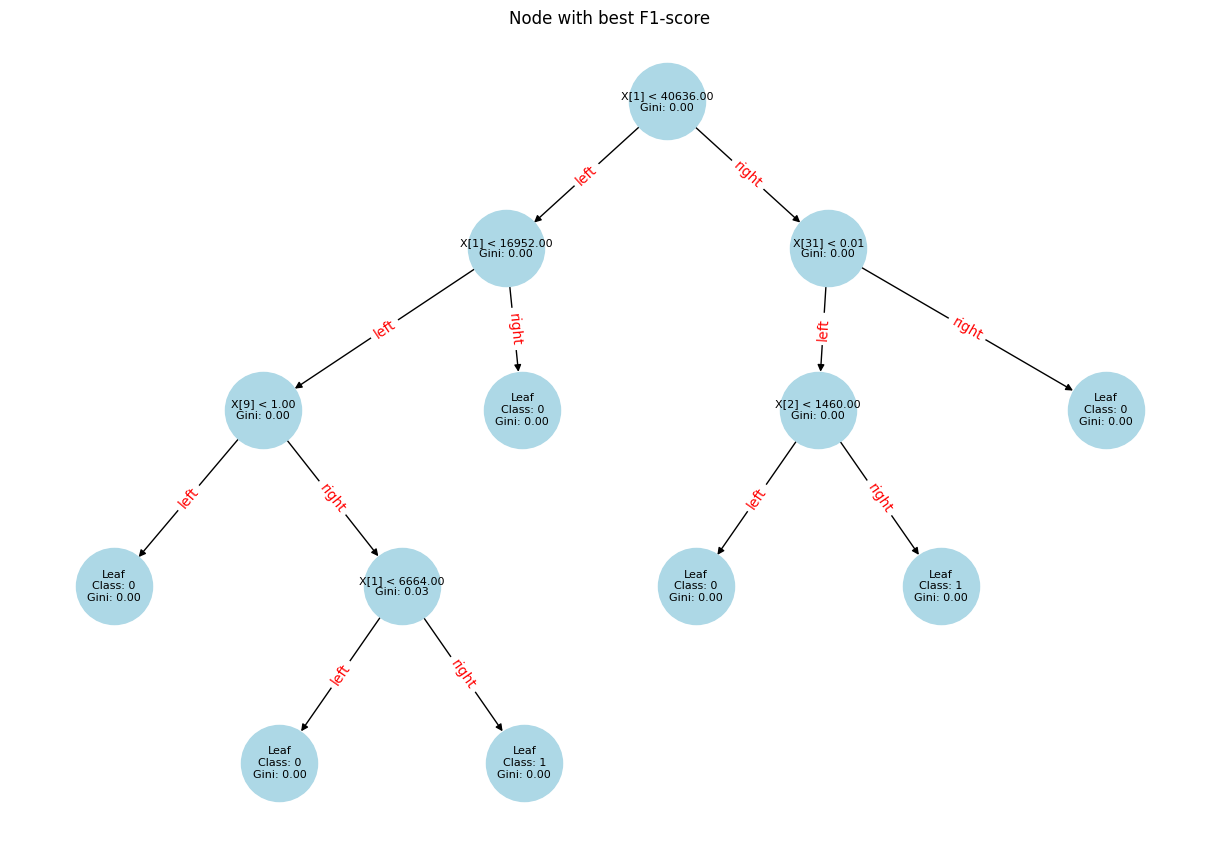

In [10]:
# Install pygraphviz if doesnot exist
try:
    import pygraphviz
except ImportError:
    print("pygraphviz not found, installing...")
    !apt-get install -y graphviz libgraphviz-dev
    !pip install pygraphviz
    import matplotlib.pyplot as plt # Try again after installing


import networkx as nx



#Functions to graphic the Best Card
def add_nodes_edges(node, graph, parent=None, edge_label=""):
    # Create a label for the node
    if node.is_leaf():
        label = f"Leaf\nClass: {node.dominant_class}\nGini: {node.gini:.2f}"
    else:
        label = f"X[{node.feature_num}] < {node.threshold_value:.2f}\nGini: {node.gini:.2f}"
    node_id = id(node)
    graph.add_node(node_id, label=label)
    if parent is not None:
        graph.add_edge(parent, node_id, label=edge_label)
    # Recursively add children
    if node.node_left is not None:
        add_nodes_edges(node.node_left, graph, node_id, "left")
    if node.node_right is not None:
        add_nodes_edges(node.node_right, graph, node_id, "right")

def plot_cart_tree(root_node):
    G = nx.DiGraph()
    add_nodes_edges(root_node, G)
    pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
    labels = nx.get_node_attributes(G, 'label')
    edge_labels = nx.get_edge_attributes(G, 'label')
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, node_color='lightblue', font_size=8)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title("Node with best F1-score")
    plt.axis('off')
    plt.show()

print("Node with best F1-score: ",bestF1Score)
plot_cart_tree(bestNode)

### Como se podria hacer mas eficiente la construccion del arbol y su evaluacion, usando la distancia de Jensen-Shannon previamente implementada?

#Podría utilizar la distancia de Jensen-Shannon para filtrar las características, seleccionando solo aquellas con una distancia mayor a 0.3 (o el top-N con mayor JS). Así, el árbol CART solo procesaría y evaluaría splits sobre estas características relevantes, evitando comparaciones innecesarias sobre datos poco informativos. Esto haría más eficiente tanto la construcción como la evaluación del árbol, ya que se reduciría el espacio de búsqueda y el número de operaciones requeridas.